Saved to extracted_features.csv
         Image    Label  Smoothness  Average Amplitude  Irregularities  \
0  V01HO01.png  Healthy    0.032902           0.034062             240   
1  V02HO01.png  Healthy    0.022339           0.022861             182   
2  V03HO01.png  Healthy    0.034711           0.036008             197   
3  V04HO01.png  Healthy    0.033286           0.034474             274   
4  V05HO01.png  Healthy    0.032303           0.033420             219   

   Peak Count  Trough Count  Zero Crossings  Wave Energy  Signal Entropy  \
0           0             0               1  2837.058883        2.249583   
1           0             0               1  2726.760385        2.300702   
2           0             0               1  1679.895600        2.277290   
3           0             0               1  2483.158115        2.275869   
4           0             0               1  2028.923169        2.276710   

   Skewness  Kurtosis  Dominant Frequency  
0 -0.366159 -1.042525 

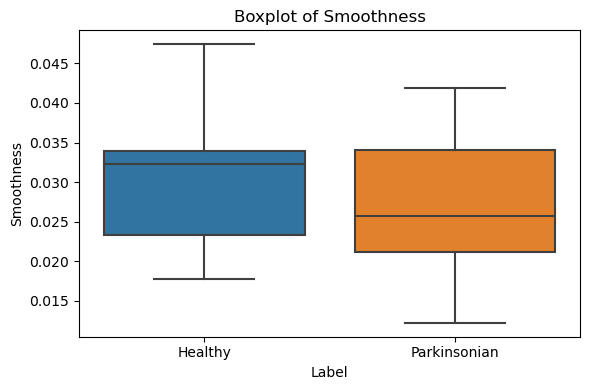

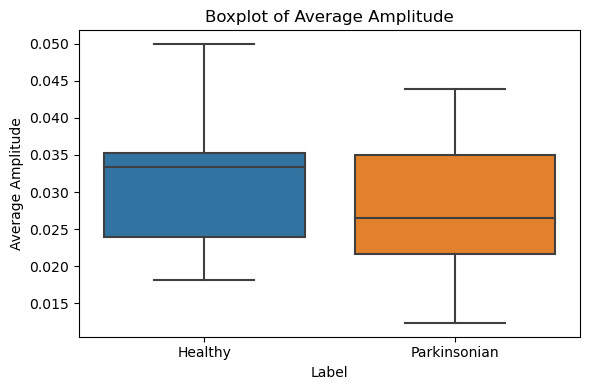

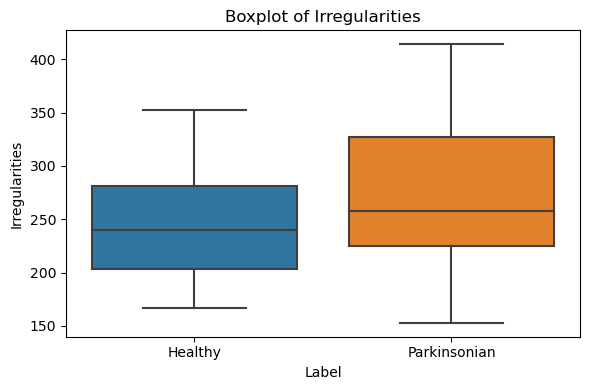

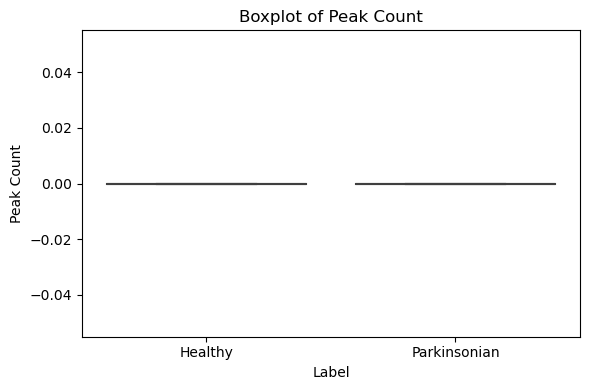

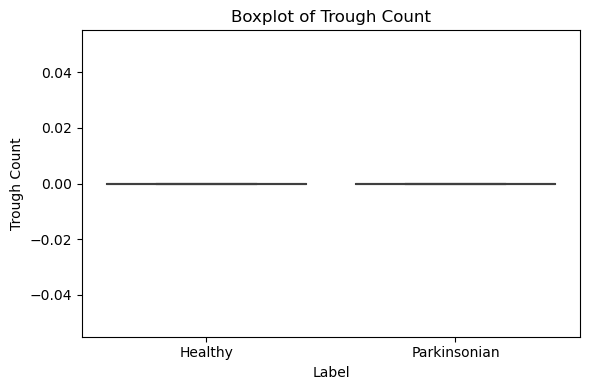

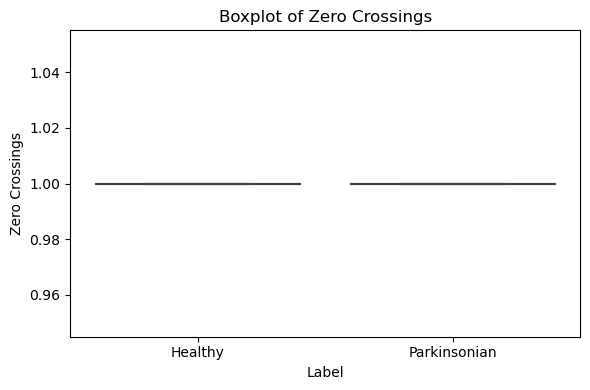

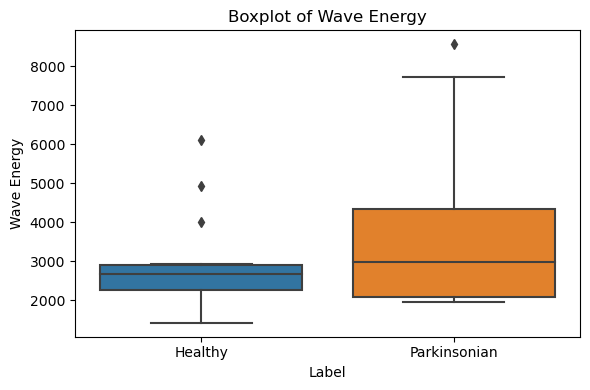

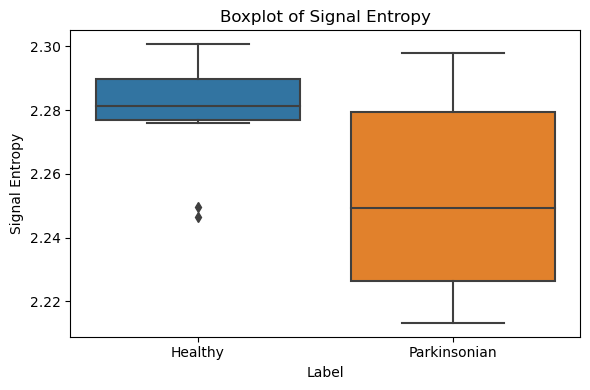

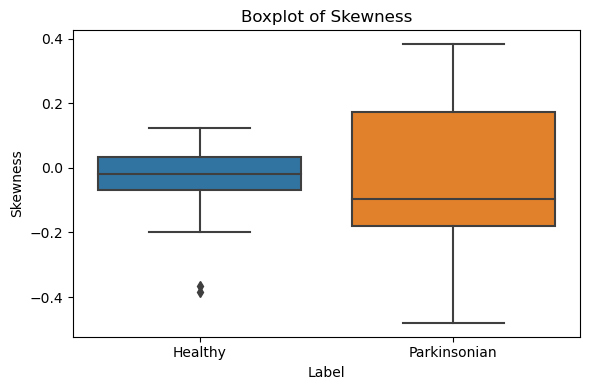

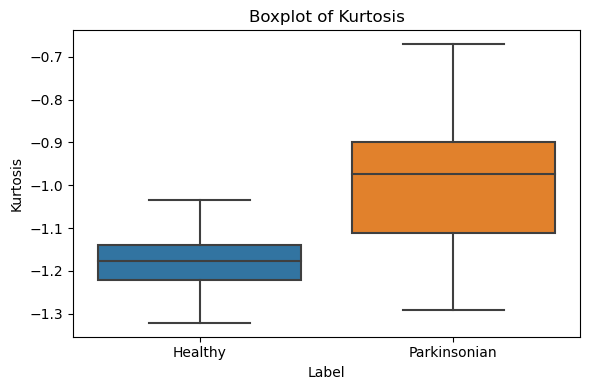

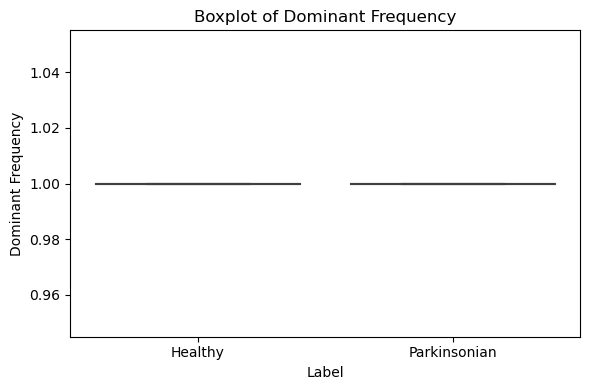

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, skew, kurtosis
from scipy.fftpack import fft

def extract_wave_features(y_coordinates):
    """Extract wave-based features from y-coordinates."""
    if len(y_coordinates) < 2:
        return [np.nan] * 9

    # Normalize
    signal = (y_coordinates - np.min(y_coordinates)) / (np.max(y_coordinates) - np.min(y_coordinates) + 1e-6)
    signal_diff = np.diff(signal)

    # Peaks and troughs
    peaks, _ = find_peaks(signal)
    troughs, _ = find_peaks(-signal)

    # Zero crossings
    zero_crossings = np.where(np.diff(np.sign(signal - np.mean(signal))))[0]

    # Energy
    energy = np.sum(signal ** 2)

    # Entropy (histogram based)
    hist, _ = np.histogram(signal, bins=10, density=True)
    signal_entropy = entropy(hist + 1e-6)

    # Skewness & Kurtosis
    sk = skew(signal)
    kurt_val = kurtosis(signal)

    # FFT and Dominant Frequency
    spectrum = np.abs(fft(signal))
    dom_freq = np.argmax(spectrum[1:]) + 1

    return [
        len(peaks),
        len(troughs),
        len(zero_crossings),
        energy,
        signal_entropy,
        sk,
        kurt_val,
        dom_freq
    ]

def extract_features(image_path):
    """Extract standard and extra wave features from an image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    y_coordinates = np.argwhere(edges > 0)[:, 0]

    if len(y_coordinates) < 2:
        return [np.nan] * 12

    # Core Features
    amplitude_diff = np.diff(y_coordinates)
    smoothness = np.var(amplitude_diff)
    avg_amplitude = np.mean(amplitude_diff)
    irregularities = len(np.where(np.abs(amplitude_diff) > avg_amplitude * 1.5)[0])

    # Extra Features
    extra = extract_wave_features(y_coordinates)

    return [smoothness, avg_amplitude, irregularities] + extra

def process_folder(folder_path, label):
    """Processes all images in a folder and extracts features."""
    data = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)
            features = extract_features(image_path)
            data.append({
                "Image": filename,
                "Label": label,
                "Smoothness": features[0],
                "Average Amplitude": features[1],
                "Irregularities": features[2],
                "Peak Count": features[3],
                "Trough Count": features[4],
                "Zero Crossings": features[5],
                "Wave Energy": features[6],
                "Signal Entropy": features[7],
                "Skewness": features[8],
                "Kurtosis": features[9],
                "Dominant Frequency": features[10]
            })
    return data

# === Set Folder Paths ===
#healthy_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\wave\training\Healthy'
#parkinsonian_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\wave\training\Parkinson'
healthy_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\wave\testing\Healthy'
parkinsonian_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\wave\testing\Parkinson'

# === Process Images ===
healthy_data = process_folder(healthy_folder, "Healthy")
parkinsonian_data = process_folder(parkinsonian_folder, "Parkinsonian")
all_data = healthy_data + parkinsonian_data
df = pd.DataFrame(all_data)

# === Save and Preview ===
#df.to_csv("extracted_featuresnewonly.csv", index=False)
df.to_csv("extracted_featuresnewonlytesting.csv", index=False)
print("Saved to extracted_features.csv")
print(df.head())

# === Summary Stats ===
print("\n=== Summary Statistics by Label ===")
print(df.groupby("Label").mean(numeric_only=True))

# === Boxplots per Feature ===
features_to_plot = [col for col in df.columns if col not in ['Image', 'Label']]
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()
    plt.show()
    
# Create a directory to save the plots
output_dir = "boxplots"
os.makedirs(output_dir, exist_ok=True)

# Generate and save boxplots
features_to_plot = [col for col in df.columns if col not in ['Image', 'Label']]
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()

    # Save the plot as a JPEG file
    filename = os.path.join(output_dir, f"boxplot_{feature}.jpeg")
    plt.savefig(filename, format='jpeg', dpi=300)
    plt.close()  # Close the figure to free up memory


In [3]:
# === Descriptive Statistics for Each Feature by Label ===
print("\n=== Full Descriptive Statistics by Label ===")

# Get grouped descriptive stats
grouped_stats = df.groupby("Label")[features_to_plot].describe()

# Loop through features and print cleanly
for feature in features_to_plot:
    print(f"\n📊 === {feature} ===")
    display(grouped_stats[feature])  # works in Jupyter / shows nicely in console

    


=== Full Descriptive Statistics by Label ===

📊 === Smoothness ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.034951,0.012372,0.015017,0.024259,0.036767,0.044180,0.059681
Parkinsonian,36.0,0.028271,0.012923,0.007047,0.020249,0.027805,0.038059,0.053296



📊 === Average Amplitude ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.036453,0.013343,0.015249,0.024878,0.038229,0.046327,0.063744
Parkinsonian,36.0,0.029299,0.013739,0.007097,0.020678,0.028625,0.039630,0.056487



📊 === Irregularities ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,256.666667,46.791941,167.0,222.75,246.5,277.0,352.0
Parkinsonian,36.0,281.361111,85.255298,137.0,229.75,261.0,308.0,510.0



📊 === Peak Count ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parkinsonian,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 === Trough Count ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parkinsonian,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 === Zero Crossings ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Parkinsonian,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0



📊 === Wave Energy ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,2632.224782,1192.704872,1189.219723,1878.392815,2296.278847,2985.156695,5737.219388
Parkinsonian,36.0,4155.266305,3375.693478,1321.092850,2134.287837,2527.522248,4607.575342,14159.528815



📊 === Signal Entropy ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,2.281283,0.016425,2.239277,2.276685,2.286422,2.292159,2.299331
Parkinsonian,36.0,2.258209,0.038110,2.142051,2.245575,2.264587,2.286213,2.301314



📊 === Skewness ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.020421,0.114685,-0.212624,-0.049804,0.032755,0.111369,0.206174
Parkinsonian,36.0,0.047187,0.186338,-0.418660,-0.035645,0.044689,0.154618,0.402319



📊 === Kurtosis ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,-1.169602,0.079256,-1.318914,-1.228607,-1.170263,-1.112241,-1.017085
Parkinsonian,36.0,-1.034075,0.171515,-1.272722,-1.157546,-1.073987,-0.991853,-0.563756



📊 === Dominant Frequency ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Parkinsonian,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [3]:
!pip install sdv



In [4]:
#!pip install pandas

import sys
!{sys.executable} -m pip install pandas


In [5]:
import sys
!{sys.executable} -m pip install sdv

C:\Users\adklt\anaconda3\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\adklt\anaconda3\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


🚀 Training CTGAN...
✅ Training complete.
📊 Sampling 200000 synthetic rows...
✅ Saved 2000 synthetic samples to → ctgan_synthetic_1000_per_class.csv

🔍 Running classifier-based diagnostic evaluation...

📊 Classification Report (Trained on Real → Tested on Synthetic):
              precision    recall  f1-score   support

     Healthy       0.74      0.70      0.72      1000
Parkinsonian       0.71      0.75      0.73      1000

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000



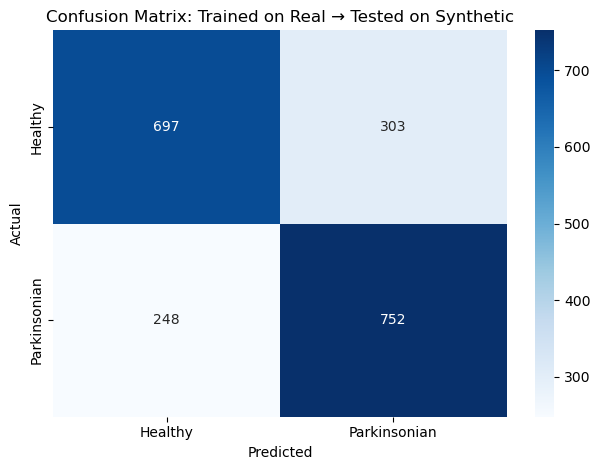


📥 Extracting True Positive synthetic samples...
✔ Found 1449 True Positives
💾 Saved 697 True Positives for Healthy → ctgan_truepositives_healthy.csv
💾 Saved 752 True Positives for Parkinsonian → ctgan_truepositives_parkinsonian.csv


In [1]:
#Enough good 18/4/2025 my last use
import pandas as pd
from sdv.single_table import CTGANSynthesizer  # You can swap with TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------
# ⚙️ CONFIGURATION
# -----------------------------------------------------
USE_TVAE = False  # Set to True to try TVAE instead of CTGAN
SYNTH_PER_CLASS = 1000
EPOCHS = 12000
SYNTH_TOTAL = 200000
SAVE_TP_FILES = True
RUN_EVALUATION = True

# -----------------------------------------------------
# 🧪 Load and preprocess real data
# -----------------------------------------------------
df_real = pd.read_csv("extracted_featuresnew.csv")
if "Image" in df_real.columns:
    df_real = df_real.drop(columns=["Image"])

df_real["Label"] = df_real["Label"].astype(str)

# -----------------------------------------------------
# 🧠 Metadata detection
# -----------------------------------------------------
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_real)

# -----------------------------------------------------
# 🚀 Train model
# -----------------------------------------------------
if USE_TVAE:
    from sdv.single_table import TVAESynthesizer
    model = TVAESynthesizer(metadata, epochs=EPOCHS)
    print("🚀 Training TVAE...")
else:
    model = CTGANSynthesizer(
        metadata,
        epochs=EPOCHS,
        batch_size=100,
        generator_lr=1e-4,
        discriminator_lr=1e-4
    )
    print("🚀 Training CTGAN...")

model.fit(df_real)
print("✅ Training complete.")

# -----------------------------------------------------
# 🎲 Sample synthetic data
# -----------------------------------------------------
print(f"📊 Sampling {SYNTH_TOTAL} synthetic rows...")
df_synth_all = model.sample(SYNTH_TOTAL)

# Filter to exactly N per class
synth_healthy = df_synth_all[df_synth_all["Label"] == "Healthy"].head(SYNTH_PER_CLASS)
synth_parkinsonian = df_synth_all[df_synth_all["Label"] == "Parkinsonian"].head(SYNTH_PER_CLASS)

df_synth = pd.concat([synth_healthy, synth_parkinsonian], ignore_index=True)

# Add synthetic image IDs
df_synth["Image"] = [
    f"Healthysynth{i+1}" if label == "Healthy" else f"Parkinsoniansynth{i+1}"
    for i, label in enumerate(df_synth["Label"])
]

output_file = "ctgan_synthetic_1000_per_class.csv"
df_synth.to_csv(output_file, index=False)
print(f"✅ Saved {len(df_synth)} synthetic samples to → {output_file}")

# -----------------------------------------------------
# 🧠 Classifier Evaluation
# -----------------------------------------------------
if RUN_EVALUATION:
    print("\n🔍 Running classifier-based diagnostic evaluation...")

    X_real = df_real.drop(columns=["Label"])
    y_real = df_real["Label"]

    X_fake = df_synth.drop(columns=["Label", "Image"])
    y_fake = df_synth["Label"]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_real, y_real)

    y_pred = clf.predict(X_fake)

    print("\n📊 Classification Report (Trained on Real → Tested on Synthetic):")
    print(classification_report(y_fake, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_fake, y_pred, labels=["Healthy", "Parkinsonian"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinsonian"],
                yticklabels=["Healthy", "Parkinsonian"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix: Trained on Real → Tested on Synthetic")
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # ✅ Save only True Positive samples
    # -----------------------------------------------------
    print("\n📥 Extracting True Positive synthetic samples...")
    true_positive_mask = y_pred == y_fake.values
    df_true_positives = df_synth[true_positive_mask]
    print(f"✔ Found {len(df_true_positives)} True Positives")

    if SAVE_TP_FILES:
        # Save full TP set
        df_true_positives.to_csv("ctgan_true_positives_all1000.csv", index=False)

        # Save per-label TPs
        for label in ["Healthy", "Parkinsonian"]:
            df_tp_label = df_true_positives[df_true_positives["Label"] == label]
            out = f"ctgan_truepositives_{label.lower()}.csv"
            df_tp_label.to_csv(out, index=False)
            print(f"💾 Saved {len(df_tp_label)} True Positives for {label} → {out}")


C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


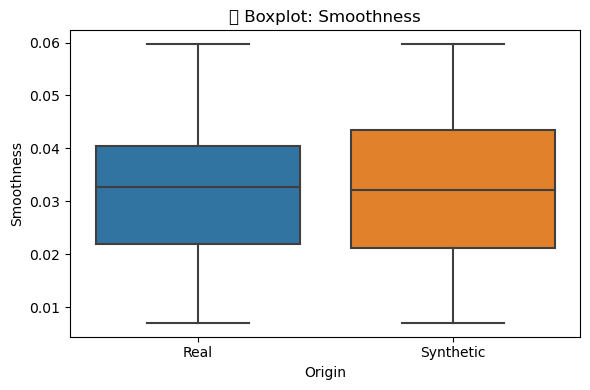

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


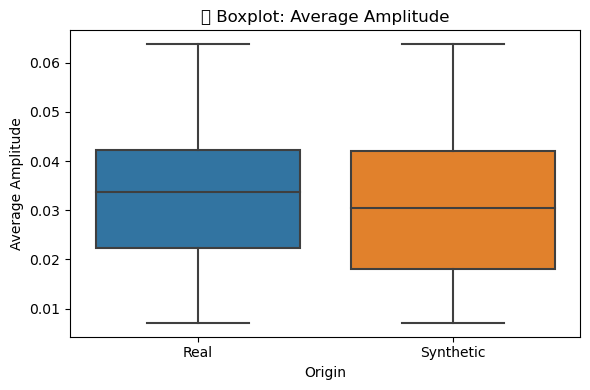

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


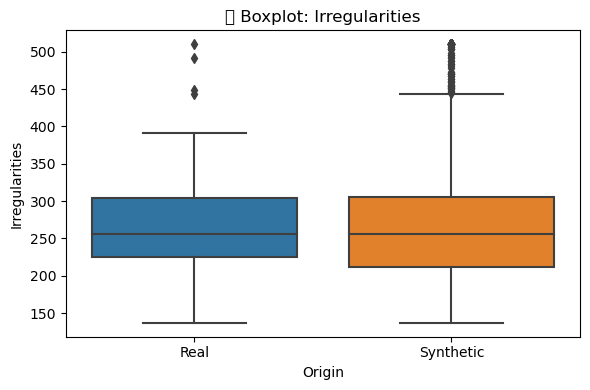

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


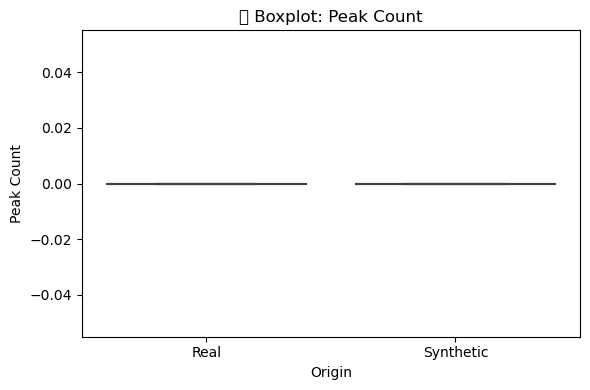

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


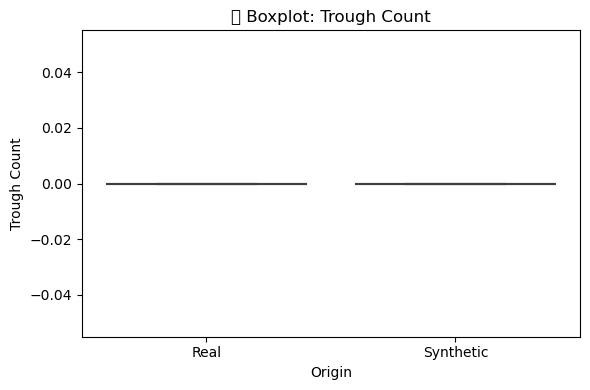

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


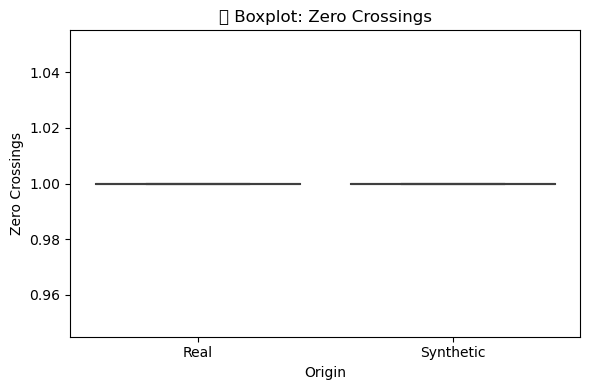

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


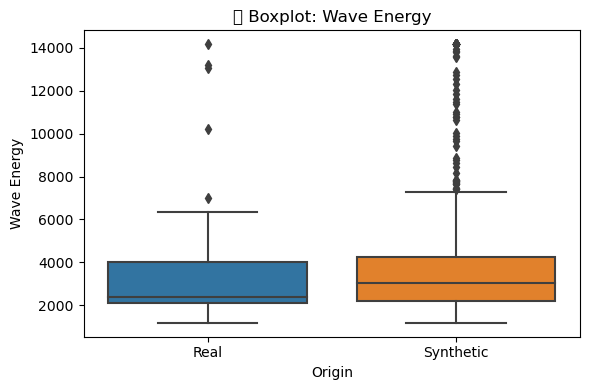

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


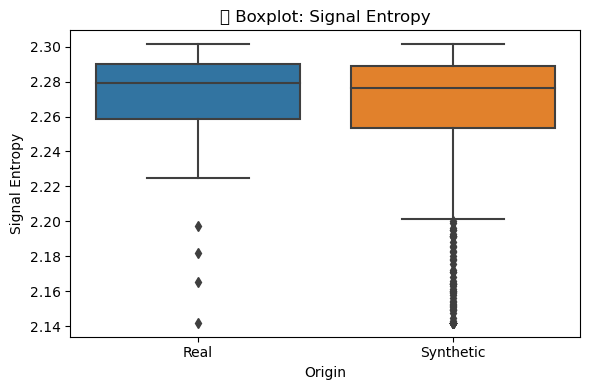

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


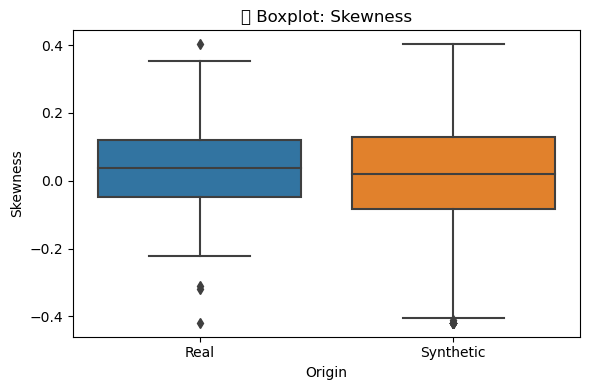

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


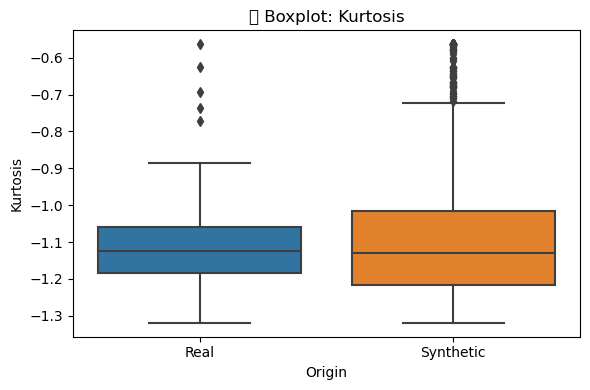

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


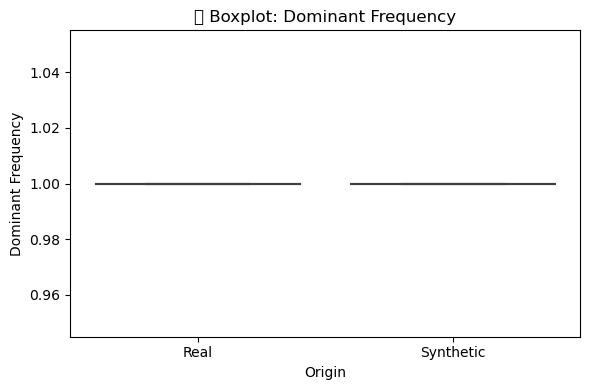

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


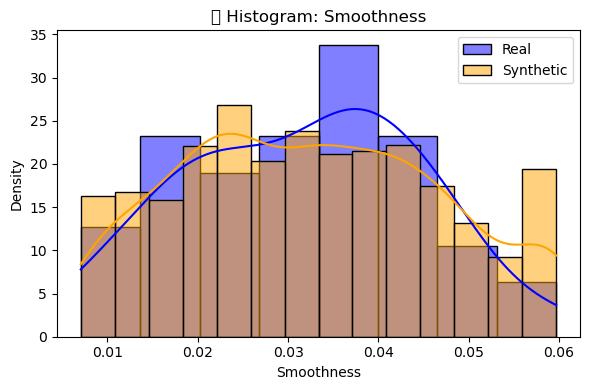

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


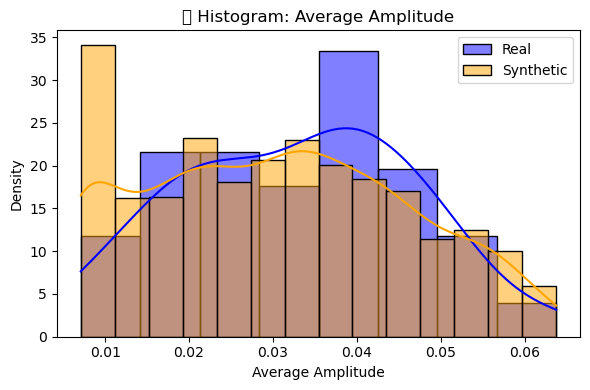

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


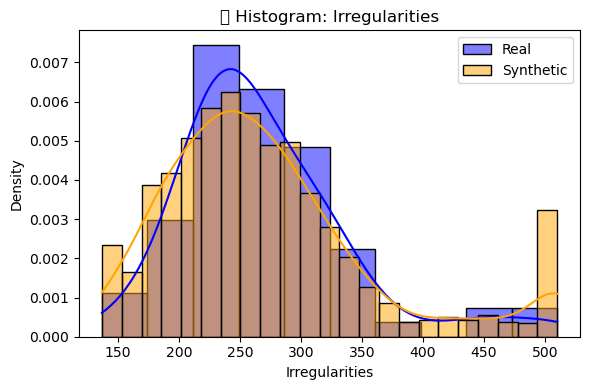

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


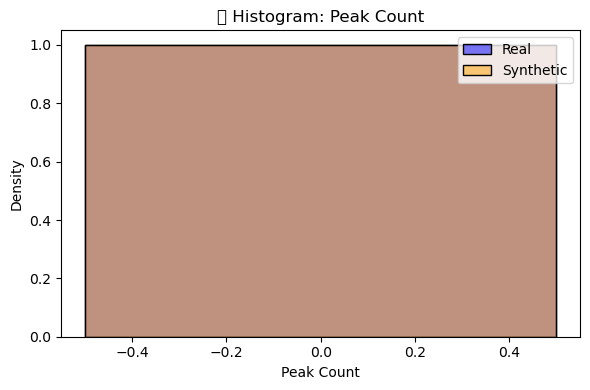

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


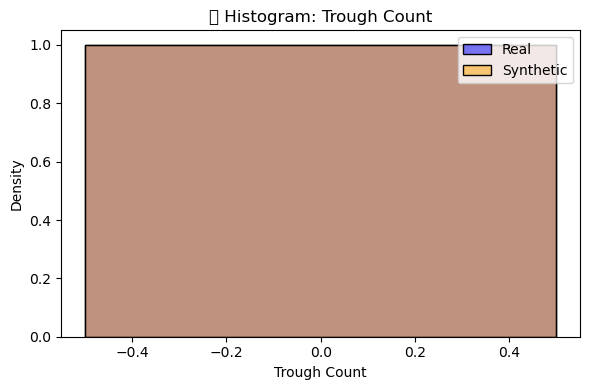

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


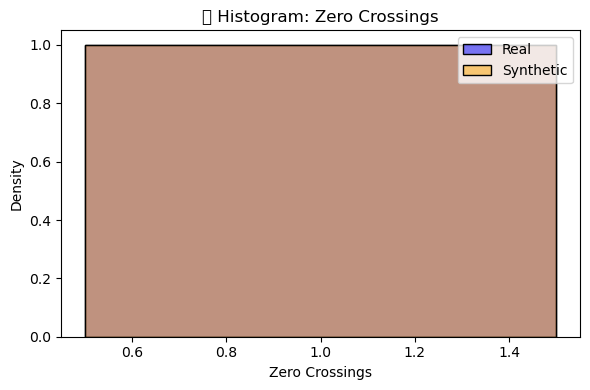

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


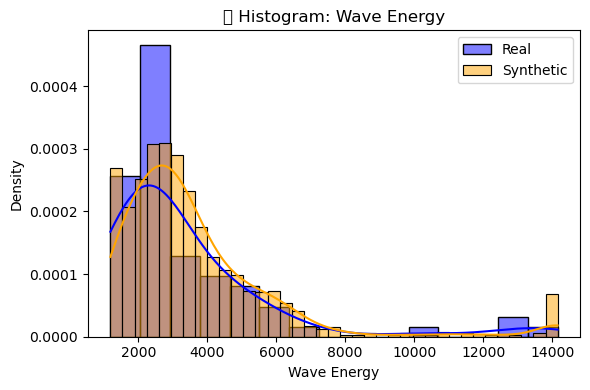

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


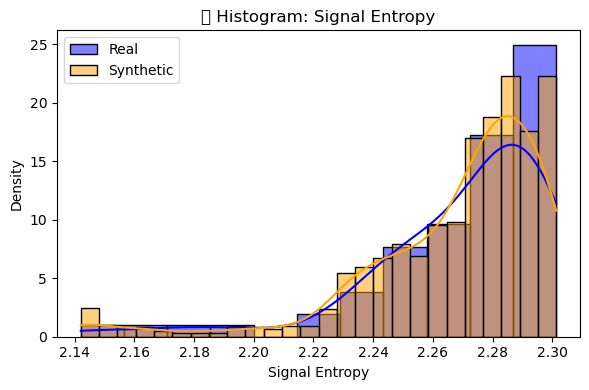

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


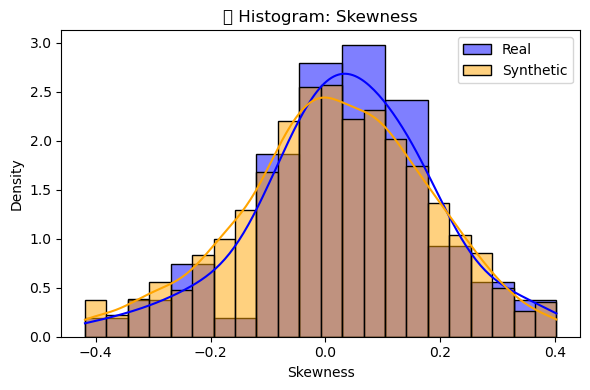

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


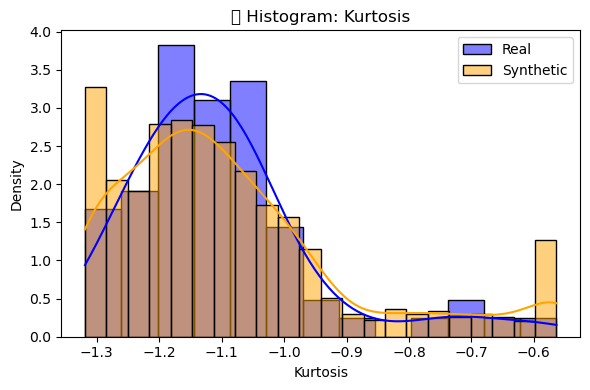

C:\Users\adklt\AppData\Local\Temp\ipykernel_5508\2970353603.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


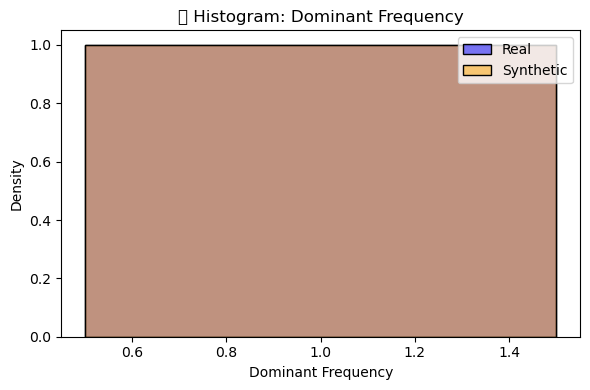

Smoothness               : p = 0.5435 → Same Distribution ✅
Average Amplitude        : p = 0.1767 → Same Distribution ✅
Irregularities           : p = 0.7873 → Same Distribution ✅
Peak Count               : Skipped (not enough variation)
Trough Count             : Skipped (not enough variation)
Zero Crossings           : Skipped (not enough variation)
Wave Energy              : p = 0.4358 → Same Distribution ✅
Signal Entropy           : p = 0.5746 → Same Distribution ✅
Skewness                 : p = 0.3554 → Same Distribution ✅
Kurtosis                 : p = 0.4395 → Same Distribution ✅
Dominant Frequency       : Skipped (not enough variation)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

# === Load real and synthetic ===
df_real = pd.read_csv("extracted_featuresnew.csv")
## df_synth = pd.read_csv("ctgan_synthetic_1000_per_class.csv")

df_synth = pd.read_csv("ctgan_true_positives_all1000.csv")

# === Match columns ===
feature_cols = [col for col in df_real.columns if col not in ["Image", "Label"]]

# === Ensure Label is same format ===
df_real["Origin"] = "Real"
df_synth["Origin"] = "Synthetic"
df_combined = pd.concat([df_real, df_synth], ignore_index=True)

# === 1. Boxplots per feature ===
for col in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Origin", y=col, data=df_combined)
    plt.title(f"📦 Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# === 2. Overlaid histograms ===
for col in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_real[col], color="blue", label="Real", kde=True, stat="density")
    sns.histplot(df_synth[col], color="orange", label="Synthetic", kde=True, stat="density")
    plt.title(f"📈 Histogram: {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 3. T-test comparison per feature ===
for col in feature_cols:
    if df_real[col].nunique() < 2 or df_synth[col].nunique() < 2:
        print(f"{col:25}: Skipped (not enough variation)")
        continue

    try:
        t_stat, p_value = ttest_ind(df_real[col], df_synth[col], equal_var=False)
        result = "Same Distribution ✅" if p_value > 0.05 else "Different ⚠️"
        print(f"{col:25}: p = {p_value:.4f} → {result}")
    except Exception as e:
        print(f"{col:25}: Error — {e}")

In [6]:
import pandas as pd

# Load the synthetic dataset (if not already loaded)
df_synth = pd.read_csv("ctgan_true_positives_all1000.csv")

# Get list of feature columns (exclude Image and Label)
feature_columns = [col for col in df_synth.columns if col not in ['Image', 'Label']]

# Group by Label and describe each feature
grouped_stats = df_synth.groupby("Label")[feature_columns].describe()

# Display per feature
for feature in feature_columns:
    print(f"\n📊 === {feature} ===")
    print(grouped_stats[feature])



📊 === Smoothness ===
              count      mean       std       min       25%       50%  \
Label                                                                   
Healthy       581.0  0.035214  0.013088  0.007047  0.023832  0.035564   
Parkinsonian  763.0  0.024110  0.012357  0.007047  0.013066  0.023092   

                   75%       max  
Label                             
Healthy       0.045739  0.059681  
Parkinsonian  0.033705  0.059681  

📊 === Average Amplitude ===
              count      mean       std       min       25%       50%  \
Label                                                                   
Healthy       581.0  0.040203  0.013306  0.007097  0.031548  0.039690   
Parkinsonian  763.0  0.028461  0.015366  0.007097  0.015656  0.027526   

                   75%       max  
Label                             
Healthy       0.049595  0.063744  
Parkinsonian  0.040379  0.063744  

📊 === Irregularities ===
              count        mean        std    min    25% 

In [5]:
!pip install shap


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       209
           1       0.94      0.92      0.93       226

    accuracy                           0.93       435
   macro avg       0.93      0.93      0.93       435
weighted avg       0.93      0.93      0.93       435

🧩 Confusion Matrix:
[[196  13]
 [ 19 207]]


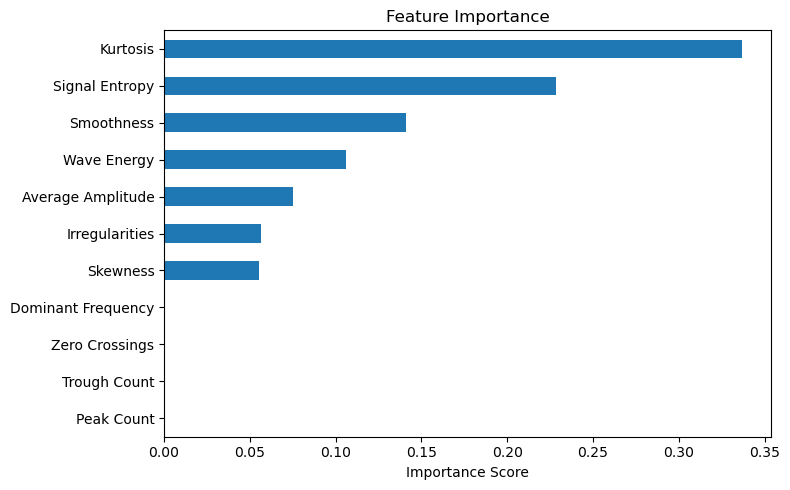

Final SHAP shape: (435, 11), X_test shape: (435, 11)


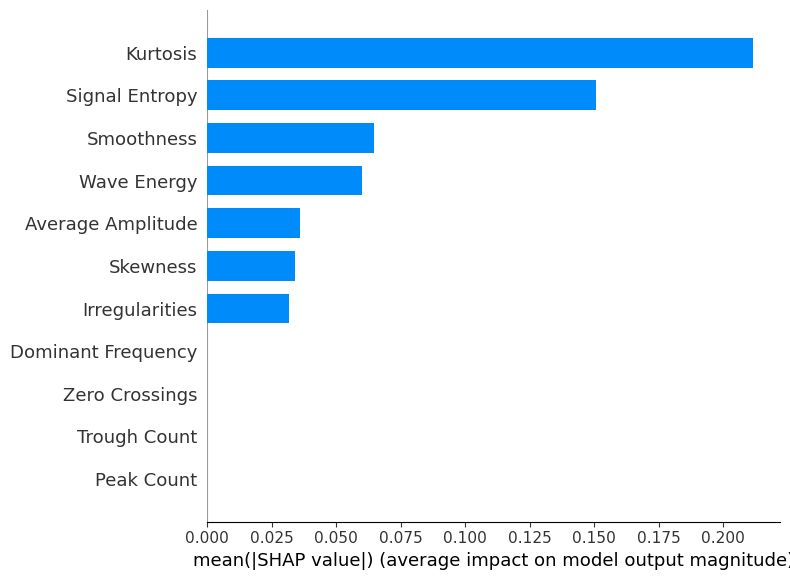

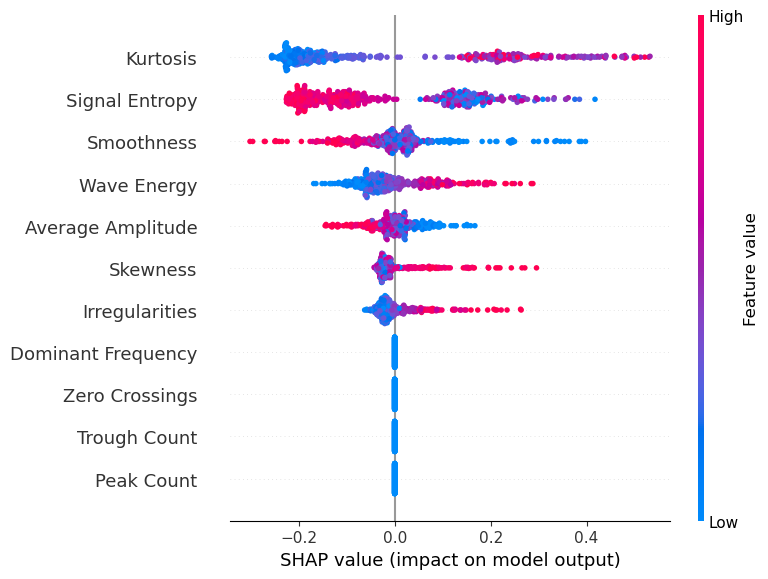

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, pearsonr, spearmanr
import shap  # <== NEW: SHAP import
import warnings
warnings.filterwarnings("ignore")  # Optional: silence warnings from SHAP/Matplotlib

# === 1. Load data ===
df = pd.read_csv("ctgan_true_positives_all1000.csv")

# === 2. Target variable (convert to 0/1) ===
df["target"] = df["Label"].map({"Healthy": 0, "Parkinsonian": 1})

# === 3. Define features (drop non-numeric or ID columns) ===
X = df.drop(columns=["Label", "Image", "target"])
y = df["target"]

# === 4. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 5. Train model ===
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# === 6. Evaluate ===
y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === 7. Feature importance (optional) ===
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(8, 5), title="Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === 8. SHAP Explanation ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# If shap_values is a list (for tree-based binary classifier), grab class 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# If still 3D, reduce to 2D using class index or mean
if shap_values.ndim == 3:
    # Example: use class 1 (assuming it's Parkinsonian)
    shap_values_reduced = shap_values[:, :, 1]
else:
    shap_values_reduced = shap_values

# Now shap_values_reduced should be (n_samples, n_features)
print(f"Final SHAP shape: {shap_values_reduced.shape}, X_test shape: {X_test.shape}")

# Plot
shap.summary_plot(shap_values_reduced, X_test, plot_type="bar")
shap.summary_plot(shap_values_reduced, X_test)




# Summary bar plot (global feature importance)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# Optional: detailed beeswarm plot
shap.summary_plot(shap_values[1], X_test)

green_features = ["Smoothness", "Kurtosis", "Signal Entropy", "Wave Energy", "Irregularities", "Skewness"]

# === Normality Tests (Shapiro-Wilk) ===
print("\n📊 Shapiro-Wilk Normality Test:")
normality = {}
for col in green_features:
    stat, p = shapiro(df[col])
    normality[col] = "Normal" if p > 0.05 else "Not Normal"
    print(f"{col:<20}: p = {p:.4f} → {normality[col]}")

# === Correlation Tests ===
print("\n🔗 Correlation with Label (0=Healthy, 1=Parkinsonian):")
for col in green_features:
    if normality[col] == "Normal":
        corr, pval = pearsonr(df[col], y)
        test = "Pearson"
    else:
        corr, pval = spearmanr(df[col], y)
        test = "Spearman"
    print(f"{col:<20}: {test:<8} r = {corr:.3f}, p = {pval:.4f}")


In [4]:
import joblib
from sklearn.metrics import accuracy_score

# === 8. Save the trained model ===
joblib.dump(model, "random_forest_ctgan_model.pkl")
print("💾 Model saved as random_forest_ctgan_model.pkl")

# ---------------------------------------------------
# 🧪 Apply model to extracted real data
# ---------------------------------------------------

# === Load real data ===
df_real = pd.read_csv("extracted_featuresnew.csv")

# Convert label to 0/1 target
df_real["target"] = df_real["Label"].map({"Healthy": 0, "Parkinsonian": 1})

# Drop non-feature columns
X_real = df_real.drop(columns=["Label", "Image", "target"], errors="ignore")
y_real = df_real["target"]

# === Load model and predict ===
model = joblib.load("random_forest_ctgan_model.pkl")
y_real_pred = model.predict(X_real)

# === Evaluate on real data ===
print("\n🔍 Evaluation on Real Data:")
print(classification_report(y_real, y_real_pred))
print("🧩 Confusion Matrix (Real Data):")
print(confusion_matrix(y_real, y_real_pred))
print(f"✅ Accuracy: {accuracy_score(y_real, y_real_pred):.4f}")


💾 Model saved as random_forest_ctgan_model.pkl

🔍 Evaluation on Real Data:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        36
           1       0.91      0.81      0.85        36

    accuracy                           0.86        72
   macro avg       0.87      0.86      0.86        72
weighted avg       0.87      0.86      0.86        72

🧩 Confusion Matrix (Real Data):
[[33  3]
 [ 7 29]]
✅ Accuracy: 0.8611


C:\Users\adklt\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=11. All the features will be returned.
  warnings.warn(
C:\Users\adklt\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 3  4  5 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\adklt\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



✅ Accuracy on test set: 66.67%

📊 Confusion Matrix (test):
[[6 4]
 [1 4]]

📋 Classification Report (test):
              precision    recall  f1-score   support

     Healthy       0.86      0.60      0.71        10
Parkinsonian       0.50      0.80      0.62         5

    accuracy                           0.67        15
   macro avg       0.68      0.70      0.66        15
weighted avg       0.74      0.67      0.68        15


🎯 Accuracy on full real data: 93.06%

📊 Confusion Matrix (real):
[[32  4]
 [ 1 35]]

📋 Classification Report (real):
              precision    recall  f1-score   support

     Healthy       0.97      0.89      0.93        36
Parkinsonian       0.90      0.97      0.93        36

    accuracy                           0.93        72
   macro avg       0.93      0.93      0.93        72
weighted avg       0.93      0.93      0.93        72

📁 Saved: real_data_with_predictions_and_eval.csv


<module 'matplotlib.pyplot' from 'C:\\Users\\adklt\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  func(*args, **kwargs)
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


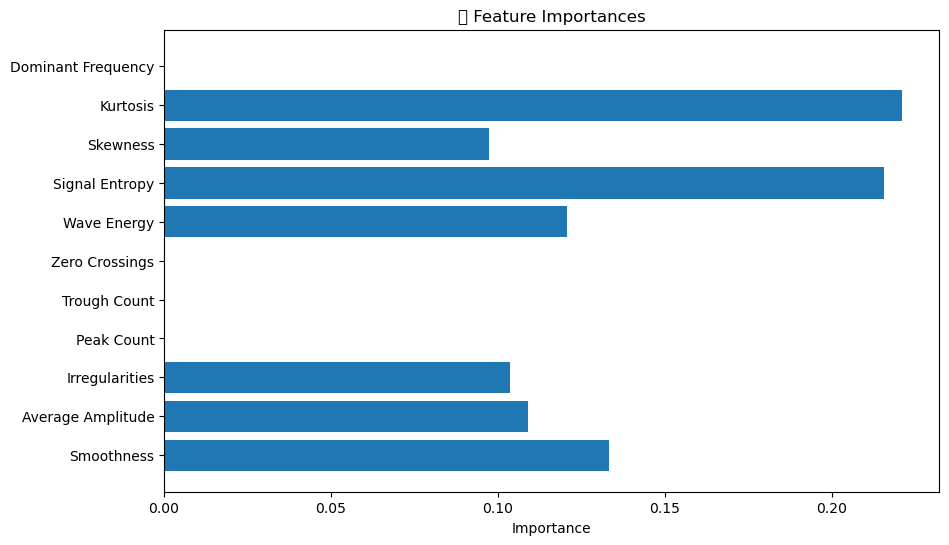

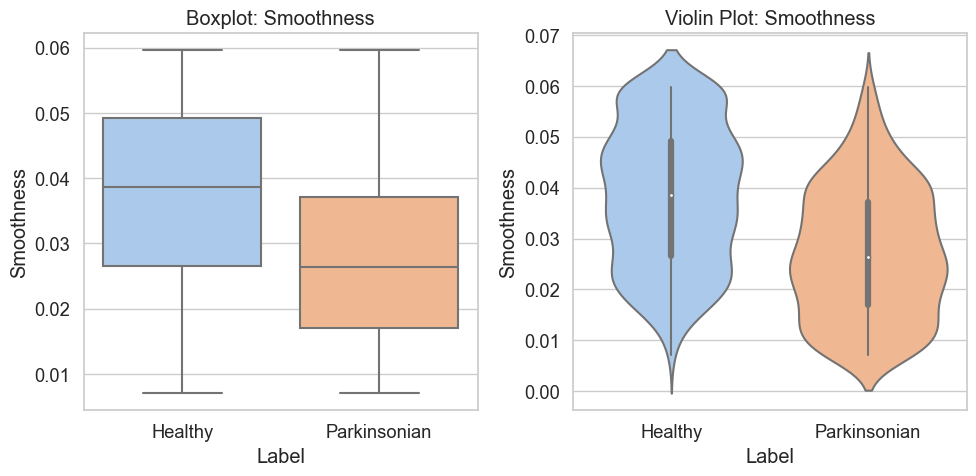

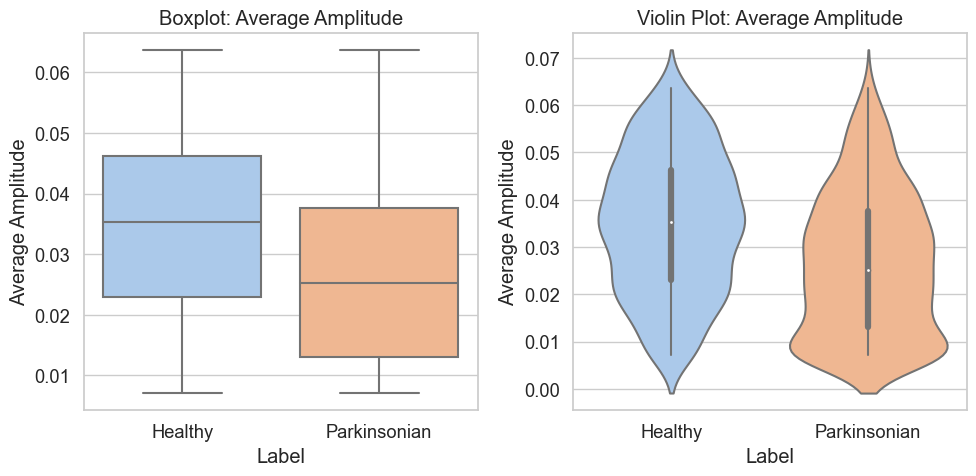

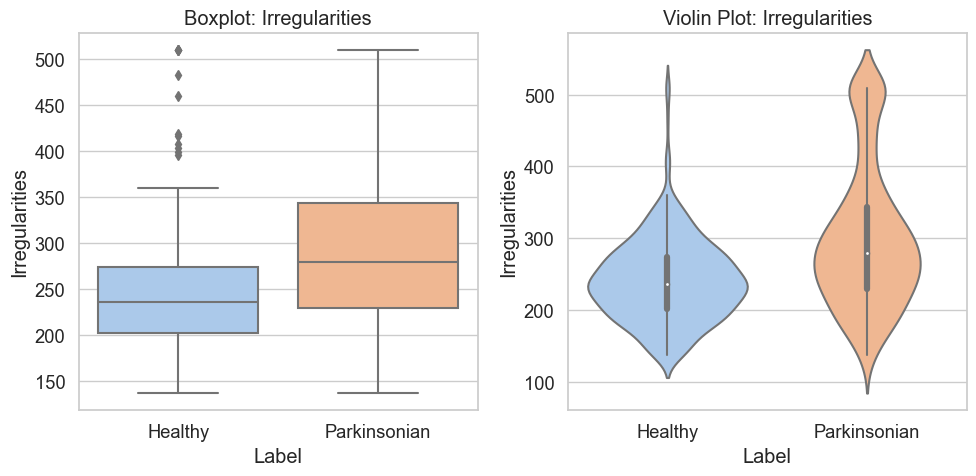

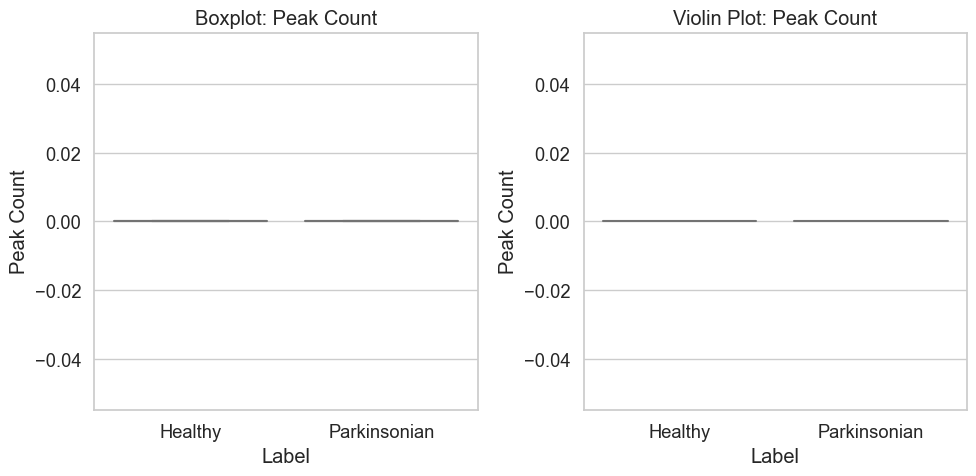

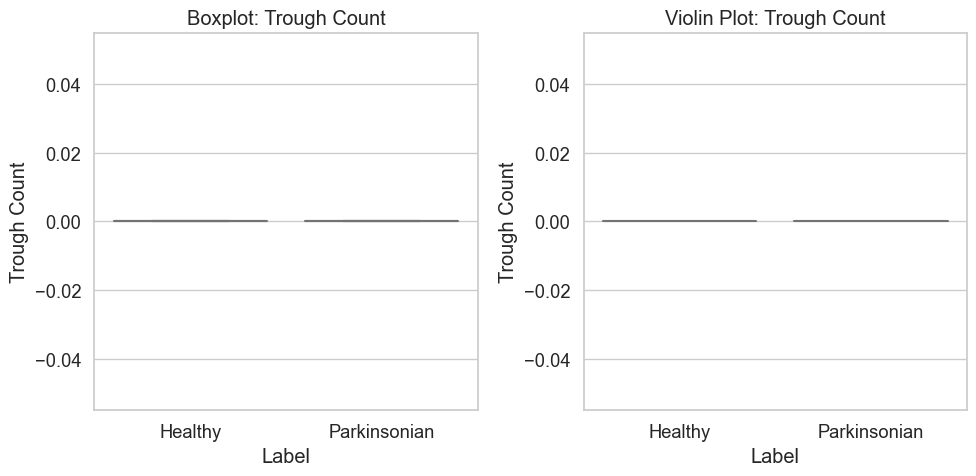

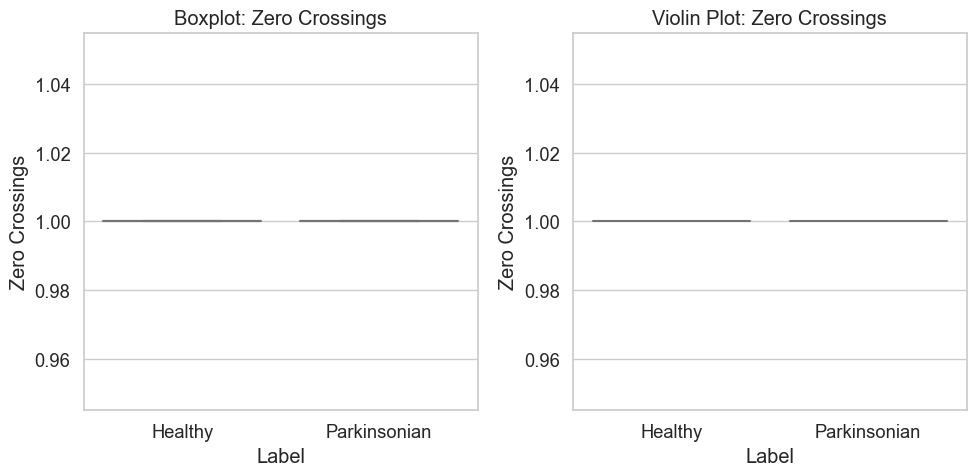

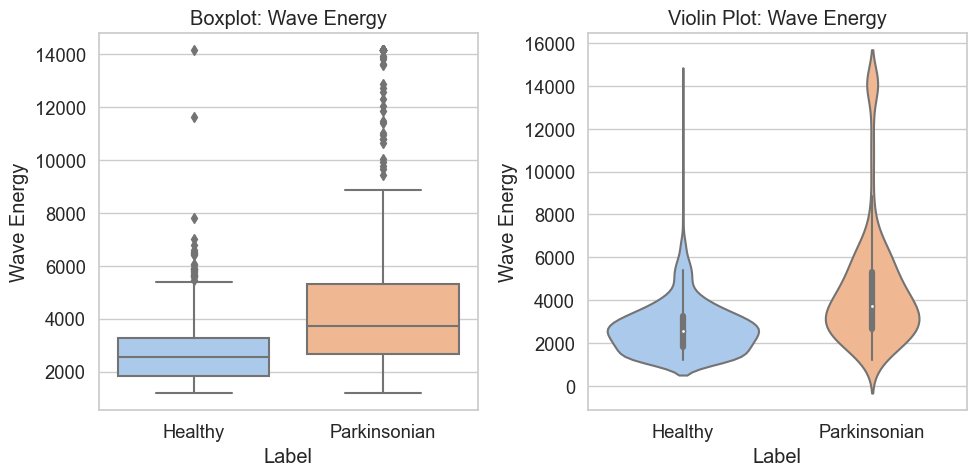

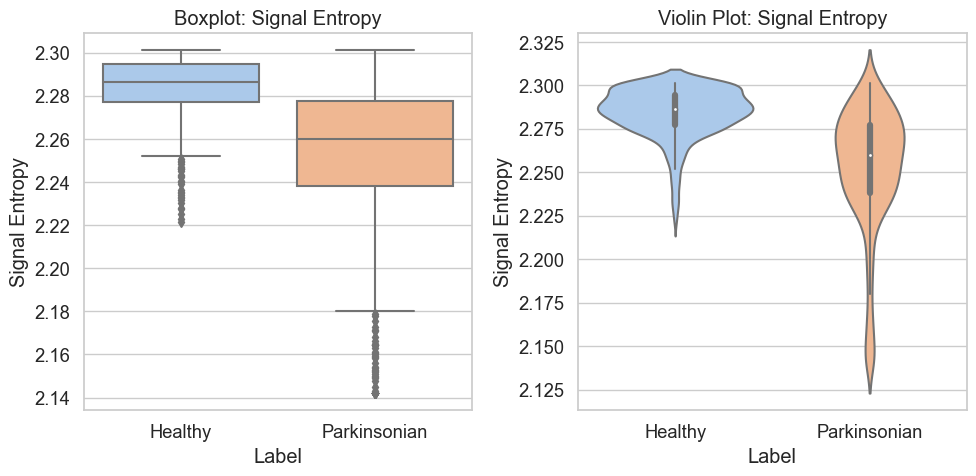

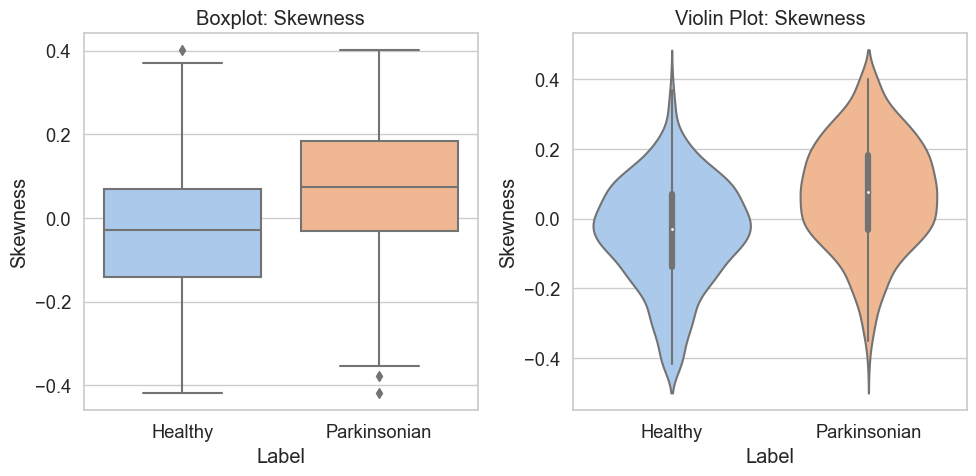

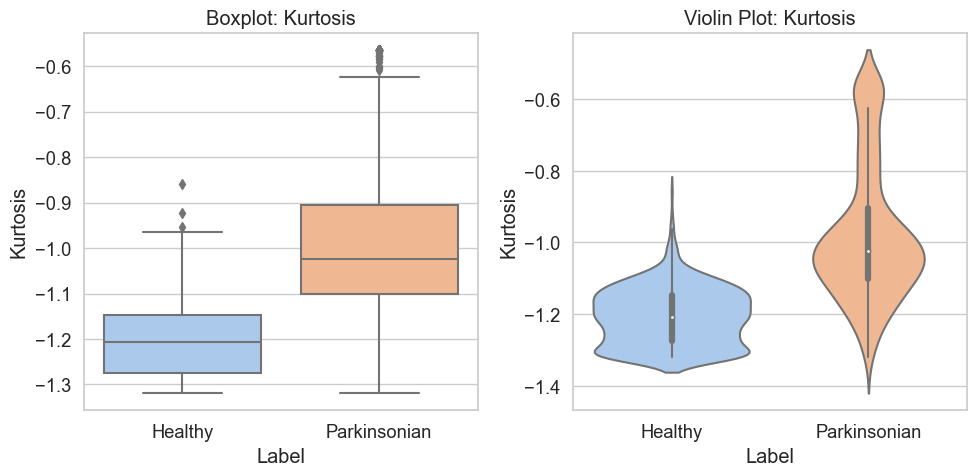

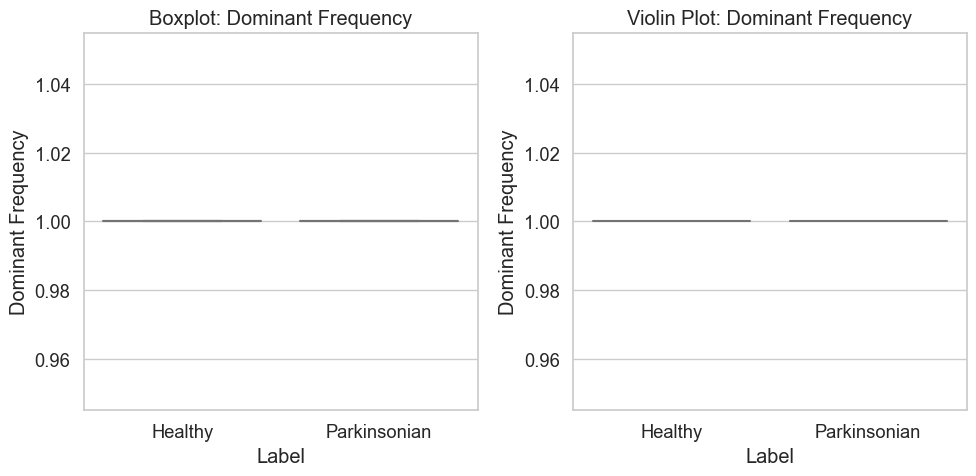

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folders if they don't exist
os.makedirs("figures", exist_ok=True)
os.makedirs("fuzzysets", exist_ok=True)

# Load data
df_synth = pd.read_csv("ctgan_true_positives_all1000.csv")
feature_columns = [col for col in df_synth.columns if col not in ['Image', 'Label']]

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

for feature in feature_columns:
    plt.figure(figsize=(10, 5))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Label', y=feature, data=df_synth)
    plt.title(f"Boxplot: {feature}")
    
    # Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='Label', y=feature, data=df_synth, inner="box")
    plt.title(f"Violin Plot: {feature}")
    
    plt.tight_layout()
    plt.savefig(f"figures/{feature}_distribution.png")
    plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# === 1. Load Data ===
df = pd.read_csv("ctgan_true_positives_all1000.csv")
os.makedirs("plots/miniplots", exist_ok=True)
os.makedirs("plots/projections", exist_ok=True)

# === 2. Get feature columns ===
feature_cols = [col for col in df.columns if col not in ['Image', 'Label']]

# === 3. Generate 10 diverse plots ===
for feature in feature_cols[:10]:  # adjust slice for more features
    plt.figure(figsize=(14, 8))
    
    # Histogram
    plt.subplot(2, 3, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} - Histogram")

    # Boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"{feature} - Boxplot")

    # Violin plot
    plt.subplot(2, 3, 3)
    sns.violinplot(x='Label', y=feature, data=df)
    plt.title(f"{feature} - Violin Plot")

    # Strip plot
    plt.subplot(2, 3, 4)
    sns.stripplot(x='Label', y=feature, data=df, jitter=True, alpha=0.5)
    plt.title(f"{feature} - Strip Plot")

    # KDE
    plt.subplot(2, 3, 5)
    sns.kdeplot(data=df, x=feature, hue='Label', fill=True)
    plt.title(f"{feature} - KDE by Label")

    # ECDF
    plt.subplot(2, 3, 6)
    for label in df['Label'].unique():
        subset = df[df['Label'] == label]
        sns.ecdfplot(subset[feature], label=label)
    plt.title(f"{feature} - ECDF")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"plots/miniplots/{feature}_summary.png")
    plt.close()

# === 4. PCA 2D and 3D ===
from sklearn.preprocessing import StandardScaler
X = df[feature_cols]
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_df_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_df_2d['Label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Label')
plt.title("PCA - 2D Projection")
plt.savefig("plots/projections/pca_2d.png")
plt.close()

# PCA 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for label in pca_df_2d['Label'].unique():
    idx = pca_df_2d['Label'] == label
    ax.scatter(X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2], label=label)
ax.set_title("PCA - 3D Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.savefig("plots/projections/pca_3d.png")
plt.close()

# === 5. t-SNE Visualization ===
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Label')
plt.title("t-SNE - 2D Projection")
plt.savefig("plots/projections/tsne_2d.png")
plt.close()

# === 6. Correlation Heatmap ===
plt.figure(figsize=(12, 10))
corr = df[feature_cols].corr()

# Create the heatmap with rotated tick labels
ax = sns.heatmap(corr, cmap='coolwarm', annot=False, cbar=True, square=True,
                 xticklabels=True, yticklabels=True)

# Rotate axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Heatmap of Features")

# Adjust layout to prevent clipping
plt.tight_layout()

# Save to file
plt.savefig("plots/projections/correlation_heatmap.png", dpi=300)
plt.close()

# === 7. Pairplot (use subset for clarity) ===
sns.pairplot(df[feature_cols[:5] + ['Label']], hue='Label')
plt.savefig("plots/projections/pairplot.png")
plt.close()

print("✅ All visualizations have been saved to the 'plots/' directory.")


✅ All visualizations have been saved to the 'plots/' directory.


✅ Saved predictions to predictions/real_data_with_rf_predictions.csv


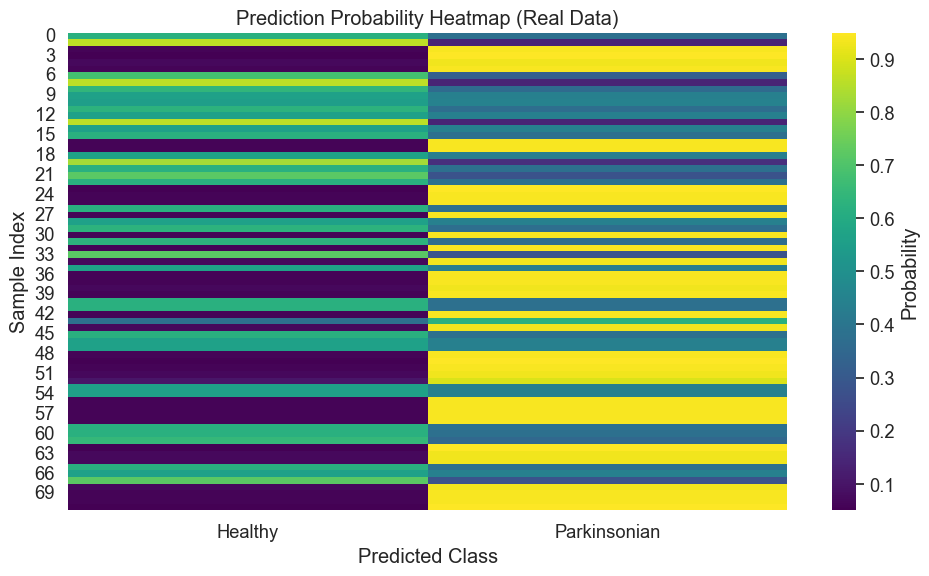

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os

# === 1. Load real dataset ===
real_df = pd.read_csv("extracted_featuresnew.csv")
real_features = real_df.drop(columns=["Image", "Label"], errors='ignore')

# === 2. Scale real data with the same method ===
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_features)

# === 3. Train model again on synthetic data for prediction ===
# (Normally you'd save/load the trained model, but here we retrain for simplicity)

# Load synthetic data
synth_df = pd.read_csv("ctgan_true_positives_all1000.csv")
X_synth = synth_df.drop(columns=["Image", "Label"], errors='ignore')
y_synth = synth_df["Label"]
if y_synth.dtype == object:
    y_synth = y_synth.map({"Healthy": 0, "Parkinsonian": 1})

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_synth, y_synth)

# === 4. Predict on real data ===
y_pred_real = rf.predict(real_scaled)
proba_real = rf.predict_proba(real_scaled)

# === 5. Attach predictions back to dataframe ===
real_df["Predicted_Label"] = y_pred_real
real_df["Predicted_Label"] = real_df["Predicted_Label"].map({0: "Healthy", 1: "Parkinsonian"})

# === 6. Save output ===
os.makedirs("predictions", exist_ok=True)
real_df.to_csv("predictions/real_data_with_rf_predictions.csv", index=False)
print("✅ Saved predictions to predictions/real_data_with_rf_predictions.csv")

# === 7. Heatmap of prediction probabilities ===
plt.figure(figsize=(10, 6))
sns.heatmap(proba_real, cmap="viridis", xticklabels=["Healthy", "Parkinsonian"], cbar_kws={'label': 'Probability'})
plt.title("Prediction Probability Heatmap (Real Data)")
plt.xlabel("Predicted Class")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.savefig("predictions/real_prediction_heatmap.png")
plt.show()


In [16]:
import pandas as pd
import numpy as np

# === 1. Load real dataset ===
df = pd.read_csv("ctgan_true_positives_all1000.csv")  # Adjust path if needed

# === 2. Selected features for fuzzy sets ===
features_to_fuzzify = [
    "Signal Entropy", 
    "Smoothness", "Kurtosis"
]

# === 3. Function to compute triangular fuzzy sets ===
def tight_fuzzy_sets(data, feature):
    values = data[feature].dropna()
    min_val = values.min()
    max_val = values.max()
    
    # Key percentiles (tight overlap)
    p20 = np.percentile(values, 20)
    p35 = np.percentile(values, 35)
    p40 = np.percentile(values, 40)
    p50 = np.percentile(values, 50)
    p60 = np.percentile(values, 60)
    p65 = np.percentile(values, 65)
    p80 = np.percentile(values, 80)
    
    return [
        {"Feature": feature, "Set": "Low",    "A": min_val, "B": p20, "C": p40},
        {"Feature": feature, "Set": "Medium", "A": p35,     "B": p50, "C": p65},
        {"Feature": feature, "Set": "High",   "A": p60,     "B": p80, "C": max_val}
    ]

# === 4. Generate fuzzy sets for all selected features ===
fuzzy_definitions = []
for feat in features_to_fuzzify:
    fuzzy_definitions.extend(tight_fuzzy_sets(df, feat))

# === 5. Save & display results ===
fuzzy_df = pd.DataFrame(fuzzy_definitions)
print("📊 Tight Fuzzy Sets with Minimal Overlap:")
print(fuzzy_df)

# Optional: save to CSV
fuzzy_df.to_csv("tight_fuzzy_sets.csv", index=False)
print("\n✅ Saved to: tight_fuzzy_sets.csv")



📊 Tight Fuzzy Sets with Minimal Overlap:
          Feature     Set         A         B         C
0  Signal Entropy     Low  2.142051  2.247265  2.270753
1  Signal Entropy  Medium  2.265899  2.276484  2.284394
2  Signal Entropy    High  2.282196  2.291570  2.301314
3      Smoothness     Low  0.007047  0.018882  0.027102
4      Smoothness  Medium  0.025078  0.032118  0.038903
5      Smoothness    High  0.036604  0.046033  0.059681
6        Kurtosis     Low -1.318914 -1.238854 -1.160034
7        Kurtosis  Medium -1.178301 -1.129060 -1.067824
8        Kurtosis    High -1.089635 -0.981657 -0.563756

✅ Saved to: tight_fuzzy_sets.csv


In [17]:
import pandas as pd

# === 1. Load your dataset ===
df = pd.read_csv("extracted_featuresnew.csv")  # Update this path if needed

# === 2. Define the updated fuzzy sets (triangular) ===
fuzzy_sets = {
    "Wave Energy": [
        ("Low", 1189.219723, 1925.035864, 2458.331934),
        ("Medium", 2280.812483, 2818.130214, 3901.356107),
        ("High", 3264.947691, 5148.650886, 14159.528815)
    ],
    "Irregularities": [
        ("Low", 141.0, 212.8, 249.0),
        ("Medium", 243.0, 271.0, 299.0),
        ("High", 287.6, 325.6, 510.0)
    ],
    "Signal Entropy": [
        ("Low", 2.142051, 2.239739, 2.265743),
        ("Medium", 2.253251, 2.276499, 2.288088),
        ("High", 2.284403, 2.292687, 2.301314)
    ],
    "Skewness": [
        ("Low", -0.479710, -0.164300, -0.036563),
        ("Medium", -0.069262, 0.022280, 0.085798),
        ("High", 0.068857, 0.187339, 0.402319)
    ],
    "Kurtosis": [
        ("Low", -1.321201, -1.252471, -1.170574),
        ("Medium", -1.186436, -1.131204, -1.070077),
        ("High", -1.094667, -0.984011, -0.563756)
    ],
    "Smoothness": [
        ("Low", 0.007047, 0.018559, 0.026212),
        ("Medium", 0.025296, 0.029371, 0.033433),
        ("High", 0.032110, 0.038441, 0.058630)
    ],
    "Average Amplitude": [
        ("Low", 0.007097, 0.015588, 0.025626),
        ("Medium", 0.023202, 0.030337, 0.037172),
        ("High", 0.035123, 0.045434, 0.063744)
    ]
}

# === 3. Triangular membership function ===
def get_membership_level(value, sets):
    best_label = None
    best_membership = -1
    for label, a, b, c in sets:
        if value <= a or value >= c:
            membership = 0
        elif a < value <= b:
            membership = (value - a) / (b - a)
        elif b < value < c:
            membership = (c - value) / (c - b)
        else:
            membership = 0
        if membership > best_membership:
            best_membership = membership
            best_label = label
    return best_label

# === 4. Apply fuzzy logic per feature ===
output_df = df[["Image"]].copy()
for feature in fuzzy_sets:
    output_df[feature + " Level"] = df[feature].apply(lambda val: get_membership_level(val, fuzzy_sets[feature]))

# === 5. Export result ===
output_df.to_csv("individuals_with_updated_fuzzy_levels.csv", index=False)
print("✅ Saved: individuals_with_updated_fuzzy_levels.csv")


✅ Saved: individuals_with_updated_fuzzy_levels.csv


In [18]:
import pandas as pd

# === 1. Load the fuzzy-level CSV ===
df = pd.read_csv("individuals_with_updated_fuzzy_levels.csv")  # Update path if needed

# === 2. Define classification logic based on fuzzy labels ===
def classify(row):
    ampli = row["Average Amplitude Level"]
    entropy = row["Signal Entropy Level"]
    kurt = row["Kurtosis Level"]
    Irreg = row["Irregularities Level"]

    # Parkinsonian rule:
    if ((kurt in ["High", "Medium"]) and
        (entropy in ["Low", "Medium"]) and
        (ampli in ["Low", "Medium"])):
        return "Parkinsonian"

    # Healthy rule:
    elif ((ampli in ["High", "Medium"]) and
          (kurt == "Low") and
          (entropy == "High")):
        return "Healthy"

    # Not matching any rule
    else:
        return "None"

# === 3. Apply classification ===
df["Classification"] = df.apply(classify, axis=1)

# === 4. Save result ===
df.to_csv("classified_individuals_final.csv", index=False)
print("✅ Saved: classified_individuals_final.csv")



✅ Saved: classified_individuals_final.csv


In [19]:
import pandas as pd

# === 1. Load the classified dataset ===
df = pd.read_csv("classified_individuals_final.csv")  # Adjust path if needed

# === 2. Filter only the 'None' classifications ===
none_df = df[df["Classification"] == "None"]

# === 3. Save the filtered dataset ===
none_df.to_csv("none_classified_individuals.csv", index=False)
print("✅ Saved: none_classified_individuals.csv")



✅ Saved: none_classified_individuals.csv


In [20]:
import pandas as pd

# === 1. Load the "None"-classified dataset ===
df = pd.read_csv("none_classified_individuals.csv")

# === 2. Infer true label from filename ===
def infer_true_label(filename):
    if 'H' in filename:
        return "Healthy"
    elif 'P' in filename:
        return "Parkinsonian"
    else:
        return "Unknown"

df["True Label"] = df["Image"].apply(infer_true_label)

# === 3. Group by true label ===
healthy_df = df[df["True Label"] == "Healthy"]
parkinsonian_df = df[df["True Label"] == "Parkinsonian"]

# === 4. Count unique fuzzy-level patterns per group ===
features = ["Average Amplitude Level", "Signal Entropy Level", "Kurtosis Level"]

# Get most frequent patterns for Healthy
healthy_patterns = healthy_df[features].value_counts().reset_index(name="Count")
healthy_patterns["Group"] = "Healthy"

# Get most frequent patterns for Parkinsonian
parkinsonian_patterns = parkinsonian_df[features].value_counts().reset_index(name="Count")
parkinsonian_patterns["Group"] = "Parkinsonian"

# Combine and show
rule_candidates = pd.concat([healthy_patterns, parkinsonian_patterns], ignore_index=True)

# Sort for visibility
rule_candidates = rule_candidates.sort_values(by=["Group", "Count"], ascending=[True, False])

# === 5. Save the candidate rule patterns ===
rule_candidates.to_csv("candidate_fuzzy_rules_from_none.csv", index=False)
print("✅ Saved: candidate_fuzzy_rules_from_none.csv")


✅ Saved: candidate_fuzzy_rules_from_none.csv


In [22]:
import pandas as pd

# === 1. Load the full fuzzy-level dataset ===
df = pd.read_csv("classified_individuals_final.csv")  # Update path if needed

# === 2. Infer true label from filename ===
def infer_true_label(filename):
    if 'H' in filename:
        return "Healthy"
    elif 'P' in filename:
        return "Parkinsonian"
    else:
        return "Unknown"

df["True Label"] = df["Image"].apply(infer_true_label)

# === 3. Filter only known ground truth ===
df = df[df["True Label"].isin(["Healthy", "Parkinsonian"])]

# === 4. Count unique fuzzy-level patterns per group ===
features = ["Smoothness Level", "Signal Entropy Level", "Kurtosis Level"]

# Get most frequent patterns for Healthy
healthy_df = df[df["True Label"] == "Healthy"]
healthy_patterns = healthy_df[features].value_counts().reset_index(name="Count")
healthy_patterns["Group"] = "Healthy"

# Get most frequent patterns for Parkinsonian
parkinsonian_df = df[df["True Label"] == "Parkinsonian"]
parkinsonian_patterns = parkinsonian_df[features].value_counts().reset_index(name="Count")
parkinsonian_patterns["Group"] = "Parkinsonian"

# Combine and show
rule_candidates = pd.concat([healthy_patterns, parkinsonian_patterns], ignore_index=True)
rule_candidates = rule_candidates.sort_values(by=["Group", "Count"], ascending=[True, False])

# === 5. Save the candidate rule patterns ===
rule_candidates.to_csv("candidate_fuzzy_rules_full_dataset.csv", index=False)
print("✅ Saved: candidate_fuzzy_rules_full_dataset.csv")


✅ Saved: candidate_fuzzy_rules_full_dataset.csv
